In [ ]:
import os
import sys

sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.datasets as datasets
import torchvision as tv
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tqdm import tqdm

from defences.baard import ApplicabilityStage, ReliabilityStage, DecidabilityStage, BAARDOperator
from models.mnist import BaseModel
from models.cifar10 import Resnet
from models.torch_util import predict_numpy
from defences.util import get_correct_examples

In [4]:
PATH_DATA = os.path.join('..', 'data')
PATH = os.path.join('..', 'result_1')
N_CLASSES = 10
DATA = 'mnist'
MODEL_NAME = 'dnn'
# DATA = 'cifar10'
# MODEL_NAME = 'resnet'

ATTACK = 'apgd2'
EPS = 2.0

In [5]:
# Load model
transform = tv.transforms.Compose([tv.transforms.ToTensor()])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if DATA == 'mnist':
    model = BaseModel(use_prob=True).to(device)
    dataset_train = datasets.MNIST(PATH_DATA, train=True, download=True, transform=transform)
else:
    model = Resnet(use_prob=True).to(device)
    dataset_train = datasets.CIFAR10(PATH_DATA, train=True, download=True, transform=transform)
file_model = os.path.join(PATH, '{}_{}_model.pt'.format(DATA, MODEL_NAME))
model.load_state_dict(torch.load(file_model))

<All keys matched successfully>

In [6]:

tensor_X, tensor_y = get_correct_examples(model, dataset_train, device=device, return_tensor=True)
X_train = tensor_X.detach().numpy()
y_train = tensor_y.detach().numpy()

In [7]:
# Initialize BAARD
stages = []
stages.append(ApplicabilityStage(n_classes=N_CLASSES))
stages.append(ReliabilityStage(n_classes=N_CLASSES))
stages.append(DecidabilityStage(n_classes=N_CLASSES))
detector = BAARDOperator(stages=stages)

In [8]:
# Load training data
file_baard_train = os.path.join(PATH, '{}_{}_baard_s1_train_data.pt'.format(DATA, MODEL_NAME))
obj = torch.load(file_baard_train)
X_baard_train = obj['X']
y_baard_train = obj['y']

In [9]:
# Load thresholds
file_baard_threshold = os.path.join(PATH, '{}_{}_baard_threshold.pt'.format(DATA, MODEL_NAME))
detector.load(file_baard_threshold)

Load from: ../result_1/mnist_dnn_baard_threshold.pt


In [10]:
stages[0].fit(X_baard_train, y_baard_train)
stages[1].fit(X_train, y_train)
stages[2].fit(X_train, y_train)

dataset_train = datasets.MNIST(PATH_DATA, train=True, download=True, transform=transform)


In [11]:
file_data = os.path.join(PATH, '{}_{}_{}_{}.pt'.format(DATA, MODEL_NAME, ATTACK, EPS))
obj = torch.load(file_data)
X = obj['X']
y = obj['y']
adv = obj['adv']

print(X.shape, y.shape, adv.shape)

(6000, 1, 28, 28) (6000,) (6000, 1, 28, 28)


In [12]:
pred_adv = predict_numpy(model, adv, device)

np.mean(pred_adv == y)

0.1445

In [13]:
X_def_test = (X[:1000])[:100]
y_def_test = (y[:1000])[:100]
adv_def_test = (adv[:1000])[:100]
pred_adv_def_test = (pred_adv[:1000])[:100]
    
X_def_val = (X[1000:2000])[:100]
y_def_val = (y[1000:2000])[:100]
adv_def_val = (adv[1000:2000])[:100]
pred_adv_def_val = (pred_adv[1000:2000])[:100]

In [14]:
stage = 0
output_adv = stages[stage].predict(adv_def_val, pred_adv_def_val)
output_X = stages[stage].predict(X_def_val, y_def_val)
print('TPR', np.sum(output_adv), 'FPR:', np.sum(output_X))

Applicability: 100%|██████████| 10/10 [00:00<00:00, 21087.50it/s]

TPR 100 FPR: 3


In [15]:
stage = 1
output_adv = stages[stage].predict(adv_def_val, pred_adv_def_val)
output_X = stages[stage].predict(X_def_val, y_def_val)
print('TPR', np.sum(output_adv), 'FPR:', np.sum(output_X))

Reliability: 100%|██████████| 10/10 [00:00<00:00, 29.12it/s]

TPR 14 FPR: 3


In [16]:
stage = 2
output_adv = stages[stage].predict(adv_def_val, pred_adv_def_val)
output_X = stages[stage].predict(X_def_val, y_def_val)
print('TPR', np.sum(output_adv), 'FPR:', np.sum(output_X))

Decidability: 100%|██████████| 10/10 [00:03<00:00,  3.02it/s]

TPR 67 FPR: 2


In [17]:
output_adv = detector.detect(adv_def_val, pred_adv_def_val)
output_X = detector.detect(X_def_val, y_def_val)
print('TPR', np.sum(output_adv), 'FPR:', np.sum(output_X))

Decidability: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]

TPR 100 FPR: 6


In [38]:
s1 = stages[0]
s1.verbose = 0
s1.quantile = 1.0
s1.fit(X_baard_train, y_baard_train)

In [44]:
s1.quantile = 0.8
s1.fit(X_baard_train, y_baard_train)
output_X = s1.predict(X_def_val, y_def_val)
fpr = np.mean(output_X)
fpr

1.0

In [ ]:
output_adv = s1.predict(adv_def_val, pred_adv_def_val)
output_X = s1.predict(X_def_val, y_def_val)
print('TPR', np.sum(output_adv), 'FPR:', np.sum(output_X))

In [51]:
tprs1 = []
fprs1 = []

for q in tqdm(np.linspace(1, 0.8, num=50)):
    s1.quantile = q
    s1.fit(X_baard_train, y_baard_train)
    output_adv = s1.predict(adv_def_val, pred_adv_def_val)
    output_X = s1.predict(X_def_val, y_def_val)
    tpr = np.mean(output_adv)
    fpr = np.mean(output_X)
    tprs1.append(tpr)
    fprs1.append(fpr)

auc_score = auc(fprs, tprs)

100%|██████████| 50/50 [00:14<00:00,  3.52it/s]


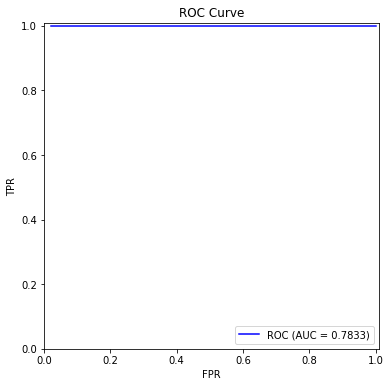

In [60]:
plt.figure(figsize=(6, 6))
plt.plot(fprs, tprs, color='blue', label='ROC (AUC = %0.4f)' % auc_score)
plt.xlim(0., 1.01)
plt.ylim(0., 1.01)
plt.legend(loc='lower right')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

In [53]:
s2 =stages[1]

In [54]:
s2.thresholds_

array([6.198775 , 3.7121754, 7.140877 , 7.1944737, 6.9155507, 7.179375 ,
       6.4525256, 6.3686037, 7.106399 , 6.6865797], dtype=float32)

In [55]:
# Let's combine
X_comb_val = np.concatenate((X_def_val, adv_def_val))
pred_comb_val = np.concatenate((y_def_val, pred_adv_def_val))
label_comb_val = np.concatenate((np.zeros_like(y_def_val), np.ones_like(pred_adv_def_val)))
labelled_as_adv = s2.predict_proba(X_comb_val, pred_comb_val)

Reliability: 100%|██████████| 10/10 [00:00<00:00, 14.59it/s]


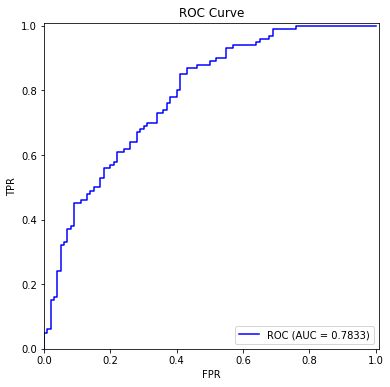

In [59]:
fpr, tpr, threshold = roc_curve(label_comb_val, labelled_as_adv)
auc_score = roc_auc_score(label_comb_val, labelled_as_adv)

plt.figure(figsize=(6, 6))
plt.xlim(0., 1.01)
plt.ylim(0., 1.01)
plt.plot(fpr, tpr, color='blue', label='ROC (AUC = %0.4f)' % auc_score)
plt.legend(loc='lower right')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [32]:
threshold

array([9.130512 , 8.130512 , 7.6207795, 7.5138927, 7.453552 , 7.3566036,
       6.9835396, 6.906995 , 6.8975606, 6.8880415, 6.672817 , 6.651941 ,
       6.533016 , 6.516126 , 6.4771276, 6.4744964, 6.371209 , 6.365042 ,
       6.3507934, 6.324317 , 6.216223 , 6.2144885, 6.204424 , 6.1854587,
       6.143692 , 6.1117935, 6.105612 , 6.0983477, 6.080734 , 6.068292 ,
       6.009271 , 6.0064273, 5.930493 , 5.8879128, 5.830012 , 5.816812 ,
       5.810652 , 5.809812 , 5.793768 , 5.743516 , 5.6735215, 5.6412416,
       5.6241307, 5.606846 , 5.5570836, 5.529444 , 5.525679 , 5.467637 ,
       5.463081 , 5.4452634, 5.430025 , 5.4014516, 5.383599 , 5.3466325,
       5.322301 , 5.313639 , 5.309786 , 5.303362 , 5.2433157, 5.2297525,
       5.127401 , 5.125446 , 5.0566764, 5.0160055, 4.9692254, 4.919749 ,
       4.9101243, 4.8838186, 4.8712564, 4.861193 , 4.8483458, 4.820459 ,
       4.701686 , 4.67559  , 4.669491 , 4.4294024, 4.4284873, 4.382    ,
       4.377814 , 4.2993574, 4.2683454, 4.267817 , 

In [33]:
fpr

array([0.  , 0.  , 0.  , 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.04, 0.04,
       0.05, 0.05, 0.06, 0.06, 0.07, 0.07, 0.08, 0.08, 0.09, 0.09, 0.11,
       0.11, 0.13, 0.13, 0.14, 0.14, 0.15, 0.15, 0.17, 0.17, 0.18, 0.18,
       0.2 , 0.2 , 0.21, 0.21, 0.22, 0.22, 0.24, 0.24, 0.26, 0.26, 0.28,
       0.28, 0.29, 0.29, 0.3 , 0.3 , 0.31, 0.31, 0.34, 0.34, 0.36, 0.36,
       0.37, 0.37, 0.38, 0.38, 0.4 , 0.4 , 0.41, 0.41, 0.43, 0.43, 0.46,
       0.46, 0.5 , 0.5 , 0.52, 0.52, 0.55, 0.55, 0.57, 0.57, 0.64, 0.64,
       0.65, 0.65, 0.68, 0.68, 0.69, 0.69, 0.76, 0.76, 1.  ])

Reliability: 100%|██████████| 10/10 [00:00<00:00, 14.46it/s]


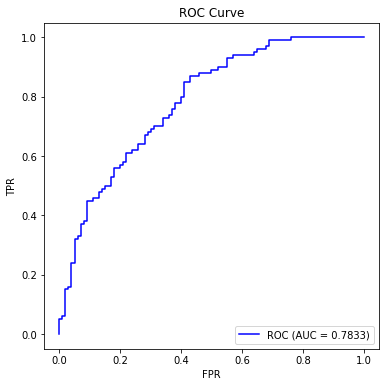

In [28]:
s3 =stages[1]
labelled_as_adv = s3.predict_proba(X_comb_val, pred_comb_val)

fpr, tpr, threshold = roc_curve(label_comb_val, labelled_as_adv)
auc_score = roc_auc_score(label_comb_val, labelled_as_adv)

plt.figure(figsize=(6, 6))
plt.xlim(0., 1.1)
plt.ylim(0., 1.1)
plt.plot(fpr, tpr, color='blue', label='ROC (AUC = %0.4f)' % auc_score)
plt.legend(loc='lower right')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()